### GOES-16 ABI and Gaylor Pit in Tuolumne

#### Analysis and plotting of snow surface and brightness temperatures (2017-2020)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

# pretty print++ and pretty print
import pprintpp
pprintpp.monkeypatch()
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs
# import function for converting GOES ABI radiance to brightness temp (goesBrightnessTemp(rad, band, fk1, fk2, bc1, bc2) )
import goes_utils



/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


In [2]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

def month_of_wy(month):
    ''' return month of wateryear (starting with October = 1, ending with September = 12)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if month>=10:
        return(month-9)
    else:
        return(month+3)
    
def week_of_wy(week):
    ''' return week of wateryear (starting with 1st week of October = 1, ending with last week of September = 52)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if week>=40:
        return(week-39)
    else:
        return(week+13)


Set font sizes for plots

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open dataset

Gaylor Pit dataset which is the merged GOES-16 brightness temperature, GOES-16 ABI Cloud Mask, and Gaylot Pit station data:

In [4]:
tuol_ds = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
tuol_ds = tuol_ds.to_xarray().squeeze()

In [5]:
# make airtemp diff fields
tuol_ds['goes_tuol_airtemp_diff'] = tuol_ds.goes_tb_c - tuol_ds.air_temp_c
tuol_ds['goes_tuol_airtemp_diff_not_orthorectified'] = tuol_ds.goes_tb_not_orthorectified_c - tuol_ds.air_temp_c

In [6]:
# approx fveg from NLCD TCC 2016 map
tuol_fveg = 0.44

wavelength_meters = 11.2e-6 # central wavelength of GOES-R ABI band 14 11.2 microns
goes_abi_band = 14 # simulate Tb seen by GOES-R ABI band 14 (centered around 11.2 microns)

# "true" (ground-based) snow temperature (add 273.15 to convert C to K)
T_snow = tuol_ds.tss+273.15
# snow emissivity
e_snow = 0.98 # from from Warren, 2019; see also Hori et al., 2006
# compute radiance around 11 micron wavelength emitted by snow at this "true" (ground-based) temperature
rad_snow = goes_utils.planck(wavelength_meters, T_snow) # in [W m-2 sr-1 m-1]
# convert radiance from [W m-2 sr-1 m-1] to [mW m-2 sr-1 (cm-1)-1]
rad_snow = goes_utils.convert_radiance_units(rad_snow, wavelength_meters) # in [mW m-2 sr-1 (cm-1)-1]
# convert this snow radiance to a snow brightness temperature that GOES ABI band 14 would see
Tb_snow = goes_utils.goesBrightnessTemp(rad_snow, band=goes_abi_band)

# "true" (ground-based) vegetation temperature (add 273.15 to convert C to K)
T_veg = tuol_ds.air_temp_c+273.15 # using Tair as a proxy for Tveg
# veg emissivity
e_veg = 0.98 # from Salisbury and D'Aria, 1992; also used in Lundquist et al., 2018
# compute radiance around 11 micron wavelength emitted by vegetation at this "true" (ground-based) temperature
rad_veg = goes_utils.planck(wavelength_meters, T_veg) # in [W m-2 sr-1 m-1]
# convert radiance from [W m-2 sr-1 m-1] to [mW m-2 sr-1 (cm-1)-1]
rad_veg = goes_utils.convert_radiance_units(rad_veg, wavelength_meters) # in [mW m-2 sr-1 (cm-1)-1]
# convert this vegetation radiance to a vegetation brightness temperature that GOES ABI band 14 would see
Tb_veg = goes_utils.goesBrightnessTemp(rad_veg, band=goes_abi_band)

# make a "surface radiance" which is a linear combination of rad_snow and rad_veg, weighted by f_veg
rad_surface = (1-tuol_fveg)*e_snow*rad_snow + tuol_fveg*e_snow*rad_veg
# convert this surface radiance to a surface brightness temperature that GOES ABI band 14 would see
Tb_sfc= goes_utils.goesBrightnessTemp(rad_surface, band=goes_abi_band)

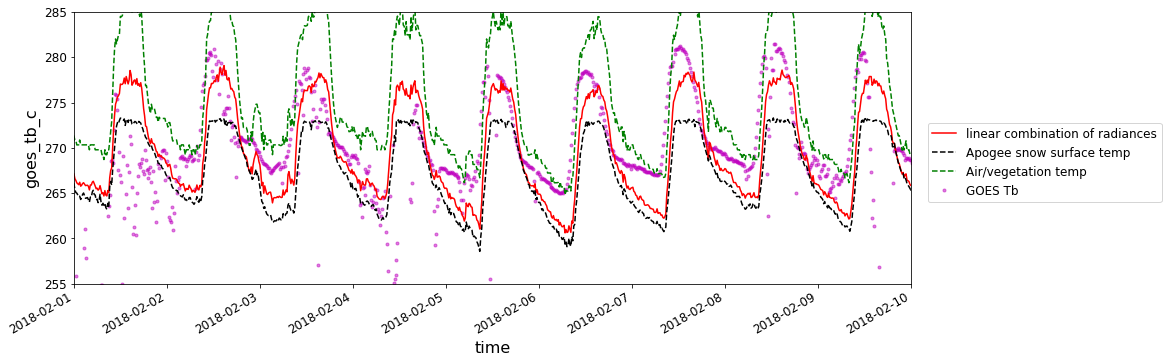

In [7]:
#Tb_sfc2 = (1-cues_fveg)*Tb_snow + cues_fveg*Tb_veg
#T_sfc = ( (1-cues_fveg) * cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'] ) + ( cues_fveg * cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'] )
#T_sfc = T_sfc + 273.15


plt.figure(figsize=(15,5))
Tb_sfc.plot(c='r', alpha=1, label='linear combination of radiances')
#Tb_sfc2.plot(c='r', alpha=0.5, label='linear combination of Tb')
#T_sfc.plot(c='b', alpha=0.5, label='linear combination of T')
T_snow.plot(c='k', linestyle='--', label='Apogee snow surface temp')
T_veg.plot(c='g', linestyle='--', label='Air/vegetation temp')
goes_tb_k = tuol_ds.goes_tb_c + 273.15
goes_tb_k.plot(c='m',linestyle='none', marker='.', zorder=-10, alpha=0.5, label='GOES Tb')
plt.xlim((pd.Timestamp('2018-2-1'),pd.Timestamp('2018-2-10')))
plt.ylim((255,285))
plt.legend(loc=(1.02,0.3))

In [8]:
# make a "surface temp" field by linear combination of "snow" and "veg" temperatures weighted by fveg
tuol_ds['sfc_temp_c'] =  Tb_sfc - 273.15
tuol_ds['goes_tuol_sfc_temp_diff'] = tuol_ds.goes_tb_c - tuol_ds.sfc_temp_c
tuol_ds['goes_tuol_sfc_temp_diff_not_orthorectified'] = tuol_ds.goes_tb_not_orthorectified_c - tuol_ds.sfc_temp_c


### Filter entire dataset to only snow-on conditions, cloud-free, November through June each year

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where ABI Cloud Mask=0.

There are very few data points within Fall months, and we don't want to look at the summer past snowmelt. Filter to only look at November through June each year.

In [9]:
# Set snow depth threshold for filtering data to snow-on conditions only
snow_depth_treshold = 5 # cm
# Set surface temperature threshold for filtering data to snow-on conditions only
surface_temperature_threshold = 0 # degrees C

##### Create a filter, combining the "snow-on" and "ABI cloud mask" filters
filter_conditions_ABIcloud_snowdepth_months = ((tuol_ds.ABI_Cloud_Mask == 0) & \
                                               (tuol_ds.daily_median_snow_depth >= snow_depth_treshold) & \
                                               (tuol_ds.tss <= surface_temperature_threshold) & \
                                               (tuol_ds.time.dt.month.isin([1,2,3,4,5,6,11,12])))
tuol_snow_abicloud = tuol_ds.where(filter_conditions_ABIcloud_snowdepth_months) # Apply this filter

In [10]:
#plt.figure(figsize=(20,5))
#
#tuol_ds.tss.plot(marker='.', c='k', markersize=1)
#tuol_ds.goes_tb_c.plot(c='grey')
#tuol_ds.goes_tb_not_orthorectified_c.plot(linestyle='--',c='grey')
#
#tuol_snow_abicloud.tss.plot(marker='.', c='r')
#tuol_snow_abicloud.goes_tb_c.plot()
#tuol_snow_abicloud.goes_tb_not_orthorectified_c.plot()
#
#plt.xlim((pd.Timestamp('2018-4-15'),pd.Timestamp('2018-4-30')))

---
---
---

# Summary stats for the full time period

And a plot showing the overal change due to orthorectifying the ABI imagery. Although we see a difference here in the timeseries, any "improvement" isn't really apparent. It is much more apparent when we look at the GOES versus ASTER plots when we can actually visually see the spatial misalignment without orthorectifying the GOES imagery.

**Plot GOES ABI versus Gaylor Pit snow surface temperature**

Not Orthorectified (original ABI projection):
{
    'intercept': -1.135540484377767,
    'max_diff': 16.648705845158965,
    'mean_diff': 1.7243694364559488,
    'mean_squared_diff': 20.49052722587741,
    'median_diff': 1.7428787800165757,
    'min_diff': -16.99834462913511,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7227117807455992,
    'r_value': 0.8501245677814512,
    'range_diff': 33.647050474294076,
    'rms_diff': 4.526646355291897,
    'slope': 0.7495057080356861,
    'std_diff': 4.185340759423777,
    'std_err': 0.0038284728584606644,
}
Orthorectified:
{
    'intercept': 1.0980478603192108,
    'max_diff': 19.696985829051812,
    'mean_diff': 4.311046108396833,
    'mean_squared_diff': 35.8281290196203,
    'median_diff': 4.19242897370452,
    'min_diff': -17.55919769745912,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7261512829056529,
    'r_value': 0.8521451067193033,
    'range_diff': 37.25618352651093,
    'rms_diff': 5.985660282677284,
    'slope'

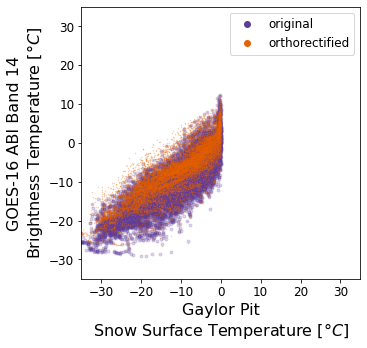

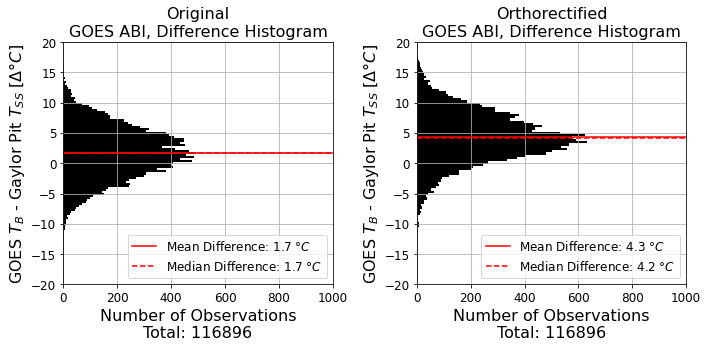

In [11]:
x1 = tuol_snow_abicloud.tss
y1 = tuol_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = tuol_snow_abicloud.tss
y2 = tuol_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.2, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.3,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=1000
ymin=-20
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
tuol_snow_abicloud.goes_tuol_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{SS}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
tuol_snow_abicloud.goes_tuol_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{SS}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

**Plot GOES ABI versus Gaylor Pit "vegetation" temperature** (remember, I'm using air temperature as an air temp proxy)

Not Orthorectified (original ABI projection):
{
    'intercept': -5.966936312859865,
    'max_diff': 7.6171324555146604,
    'mean_diff': -5.066650878888973,
    'mean_squared_diff': 40.78545860003251,
    'median_diff': -5.029336151315199,
    'min_diff': -21.101121246630875,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7339441537198202,
    'r_value': 0.8567054066129268,
    'range_diff': 28.718253702145535,
    'rms_diff': 6.386349395392685,
    'slope': 0.8053877001719459,
    'std_diff': 3.8877380919354776,
    'std_err': 0.003998778735012457,
}
Orthorectified:
{
    'intercept': -3.388721112145696,
    'max_diff': 10.574367565774871,
    'mean_diff': -2.47997420694809,
    'mean_squared_diff': 17.299776089734653,
    'median_diff': -2.328356322915916,
    'min_diff': -19.951419919681342,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7986390618659565,
    'r_value': 0.8936660796214414,
    'range_diff': 30.525787485456213,
    'rms_diff': 4.159299951883088,
    

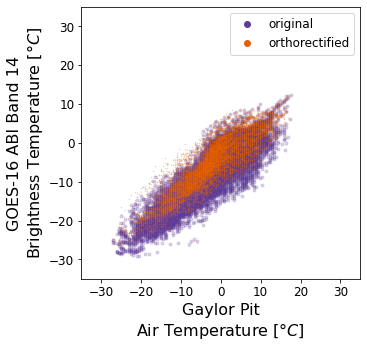

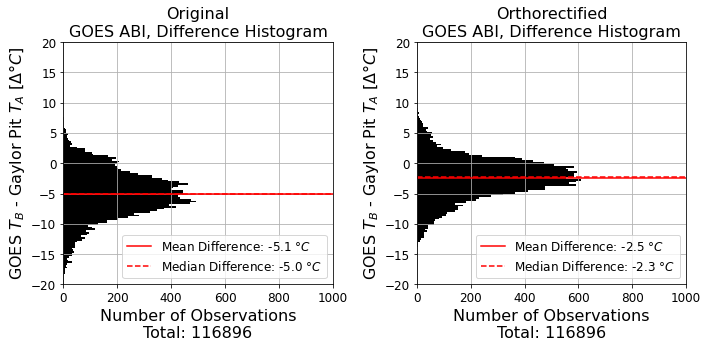

In [12]:
x1 = tuol_snow_abicloud.air_temp_c
y1 = tuol_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = tuol_snow_abicloud.air_temp_c
y2 = tuol_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.2, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.3,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('Gaylor Pit\nAir Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=1000
ymin=-20
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
tuol_snow_abicloud.goes_tuol_airtemp_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_airtemp_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{A}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
tuol_snow_abicloud.goes_tuol_airtemp_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_airtemp_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{A}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

**Plot GOES ABI versus Gaylor Pit (Tuolumne) "surface" temperature** (linear combination weighted by fveg)

Not Orthorectified (original ABI projection):
{
    'intercept': -1.887922344984613,
    'max_diff': 12.741484567120674,
    'mean_diff': -0.12153100113620297,
    'mean_squared_diff': 13.687397331054212,
    'median_diff': -0.06329447422842804,
    'min_diff': -16.83022798399557,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7594597987355622,
    'r_value': 0.8714699069592491,
    'range_diff': 29.571712551116242,
    'rms_diff': 3.699648271262312,
    'slope': 0.8154465837579195,
    'std_diff': 3.6976516259400434,
    'std_err': 0.0037844645660179703,
}
Orthorectified:
{
    'intercept': -3.388721112145696,
    'max_diff': 10.574367565774871,
    'mean_diff': -2.47997420694809,
    'mean_squared_diff': 17.299776089734653,
    'median_diff': -2.328356322915916,
    'min_diff': -19.951419919681342,
    'n': 14707,
    'p_value': 0.0,
    'r_squared': 0.7986390618659565,
    'r_value': 0.8936660796214414,
    'range_diff': 30.525787485456213,
    'rms_diff': 4.159299951883088,

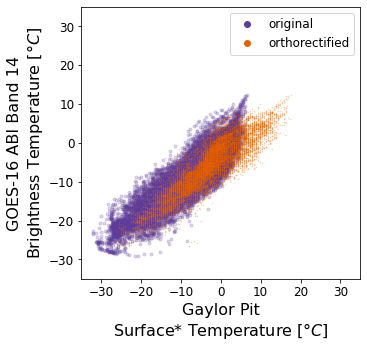

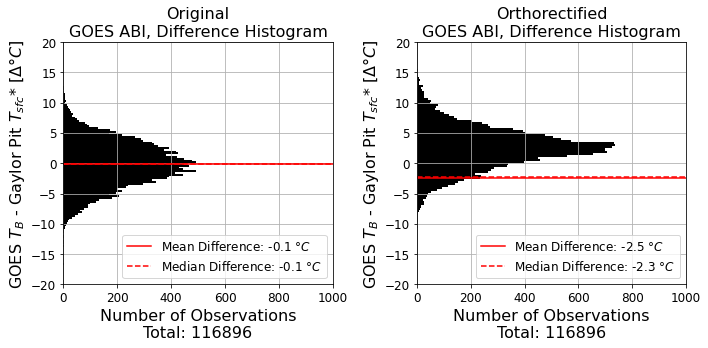

In [13]:
x1 = tuol_snow_abicloud.sfc_temp_c
y1 = tuol_snow_abicloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = tuol_snow_abicloud.air_temp_c
y2 = tuol_snow_abicloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.2, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.3,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('Gaylor Pit\nSurface* Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=1000
ymin=-20
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
tuol_snow_abicloud.goes_tuol_sfc_temp_diff_not_orthorectified.plot.hist(ax=ax1,
                                                                  bins=nbins, 
                                                                  orientation='horizontal',
                                                                  color = '#000000',
                                                                  ec='none',
                                                                  lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_sfc_temp_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{sfc}$* [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
tuol_snow_abicloud.goes_tuol_sfc_temp_diff.plot.hist(ax=ax2,
                                               bins=nbins, 
                                               orientation='horizontal',
                                               color = '#000000',
                                               ec='none',
                                               lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(tuol_snow_abicloud.goes_tuol_sfc_temp_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - Gaylor Pit $T_{sfc}$* [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

---
ASTER, MODIS, GOES timeseries for Gaylor Pit:

In [14]:
sat_timeseries = pd.read_csv('goes_modis_aster_orthorectified_tb_gaylor_timeseries.csv')
sat_timeseries['time'] = pd.to_datetime(sat_timeseries['time'])
sat_timeseries.set_index('time', inplace=True)
sat_timeseries['ast_goes_max_diff_rad2tbK'] = sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_max_rad2tbK
sat_timeseries['ast_goes_min_diff_rad2tbK'] = sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_min_rad2tbK

In [15]:
#sat_timeseries.keys()

In [16]:
#x = sat_timeseries.index.dayofyear
#
#plt.plot(x, sat_timeseries.ast_goes_aster_rad2tbK, 
#         linestyle='none', marker='o', color='r', label='ASTER pixel Tb')
#
#plt.plot(x, sat_timeseries.ast_goes_mean_rad2tbK, 
#         linestyle='none', marker='o', color='k', label='ASTER upscaled to GOES resolution Tb')
#
#plt.errorbar(x=x, 
#             y=sat_timeseries.ast_goes_mean_rad2tbK, 
#             yerr=[sat_timeseries.ast_goes_mean_rad2tbK-sat_timeseries.ast_goes_min_rad2tbK, 
#                   sat_timeseries.ast_goes_max_rad2tbK-sat_timeseries.ast_goes_mean_rad2tbK],
#             fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='k', linewidth=1, capsize=3)
#
#plt.plot(x, sat_timeseries.ast_goes_goes_tb, 
#         linestyle='none', marker='o', color='b', label='GOES Tb')
#
#plt.legend(loc=(1.1,0.5))

In [17]:
#for month in np.unique(sat_timeseries.index.month.values):
#
#    fig, ax = plt.subplots(1,1,figsize=(4,4))
#    
#    # Get ASTER (mean aggregated to GOES pixel size) Tb values for this month
#    x = sat_timeseries.ast_goes_mean_rad2tbK.where(sat_timeseries.index.month==month) - 273.15
#    # Get corresponding GOES value for these ASTER observations
#    y = sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - 273.15
#    
#    # Get ASTER min and maximum values (these are the min and max values of ASTER pixels under the GOES pixel footprint)
#    xerr_min = x - (sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month) - 273.15)
#    xerr_max = (sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month) - 273.15) - x
#    
#    # Plot ASTER Tb vs GOES Tb
#    ax.plot(x, y,  linestyle='none',marker='o',markerfacecolor='k',markeredgecolor='k')
#    
#    # Plot ASTER min/max error bars
#    plt.errorbar(x, y,
#                 xerr=[xerr_min, xerr_max],
#                 fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='k', linewidth=1, capsize=3)
#    
#    
#    # Format plot, plot 1-to-1 line
#    (axmin, axmax) = (-20, 20)
#    ax.plot([axmin,axmax],[axmin,axmax],linestyle='-',linewidth=1,color='k')
#    ax.set_xlim((axmin,axmax))
#    ax.set_ylim((axmin,axmax))
#    ax.grid()
#    ax.set_title('Month: {}'.format(month))

---

# Boxplots and Histograms

Resample, compute summary stats

In [18]:
color1='b' # Tsnow
color2='g' # Tveg
color3='k' # Tsfc

In [19]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 1M resample

In [20]:
## Compute summary stats for whole dataset
#x = tuol_snow_abicloud.tss
#y = tuol_snow_abicloud.goes_tb_c
#print("Summary Stats for full tuol_snow_cloud dataset")
#original_summary_stats = rs.summary_stats(x, y)
#pprint.pprint(original_summary_stats)
## Make a 1-to-1 plot for the same data in the histogram
#plt.figure(figsize=(4,4))
#plt.title('full tuol_snow_cloud dataset')
#plt.plot(x, y, '.k',alpha=1, markersize=1)
#(min_lim, max_lim) = (-40, 40)
#plt.xlim((min_lim,max_lim))
#plt.ylim((min_lim,max_lim));
#plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
#plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
#plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')
#
## Create DataArrayResample object
#resampled_ds = tuol_snow_abicloud.goes_tuol_diff.resample(time='1M')
## Run the resampled_stats function
#resampled_df = rs.resampled_stats(resampled_ds, 0)
#
#startdate = pd.Timestamp('2017-02-01')
#enddate = pd.Timestamp('2020-07-01')
#
## Plot the results
#fig, ax = rs.resampled_plot(tuol_snow_abicloud.goes_tuol_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1000, nbins=100)
## Add grid
#ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
#ax[1].set_xlim((startdate,enddate));
#ax[1].set_title('Difference Summary Statistics by Month, Year');
#ax[1].set_xlabel('Month, Year');
##
### add snow depth line for context
#snowdepth_ax = ax[1].twiny().twinx()
#snowdepth_ax.set_xlim((startdate,enddate));
#snowdepth_ax.set_xticklabels([])
#tuol_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=snowdepth_ax, alpha=0.5)
#snowdepth_ax.set_ylabel('Snow Depth [cm]')
##snowdepth_ax.legend(loc='upper right')

### Month of Year groupby

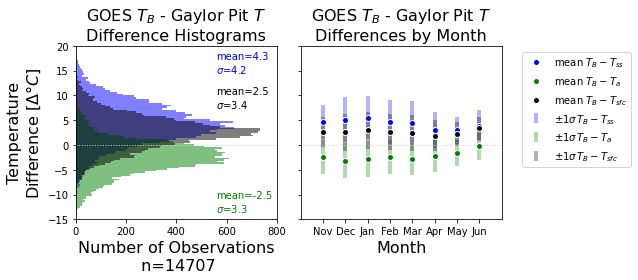

In [21]:
# Create DataArrayResample object
resampled_ds_tss = tuol_snow_abicloud.goes_tuol_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df_tss = rs.resampled_stats(resampled_ds_tss, 0)
# calculate month of wateryear from calendar month
resampled_df_tss['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df_tss.index]
resampled_df_tss.set_index('month_of_wateryear', inplace=True)
#print("Snow Surface Temperature:\n", resampled_df_tss)

# Create DataArrayResample object
resampled_ds_tair = tuol_snow_abicloud.goes_tuol_airtemp_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df_tair = rs.resampled_stats(resampled_ds_tair, 0)
# calculate month of wateryear from calendar month
resampled_df_tair['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df_tair.index]
resampled_df_tair.set_index('month_of_wateryear', inplace=True)
#print("Snow Surface Temperature:\n", resampled_df_tair)

#### add "surface" temp ###
# Create DataArrayResample object
resampled_df_tsfc = tuol_snow_abicloud.goes_tuol_sfc_temp_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df_tsfc = rs.resampled_stats(resampled_df_tsfc, 0)
# calculate month of wateryear from calendar month
resampled_df_tsfc['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df_tsfc.index]
resampled_df_tsfc.set_index('month_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot3(tuol_snow_abicloud.goes_tuol_diff.to_dataframe(), resampled_df_tss, 
                             tuol_snow_abicloud.goes_tuol_airtemp_diff.to_dataframe(), resampled_df_tair,
                             tuol_snow_abicloud.goes_tuol_sfc_temp_diff.to_dataframe(), resampled_df_tsfc,
                             ymin=-20, ymax=20, xmin=0, xmax=1000, nbins=100,
                             color1=color1,color2=color2,color3=color3)

### Add GOES-ASTER difference by hour of day for this month
#x = [month_of_wy(month) for month in sat_timeseries.index.month.values] # Get month of wy
#y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference for this month
#yerr_min = sat_timeseries.ast_goes_min_diff_rad2tbK
#yerr_max = sat_timeseries.ast_goes_max_diff_rad2tbK
#_yerr_min = yerr_min.groupby(yerr_min.index.month).min() # groupby month, monthly minimum
#_yerr_max = yerr_max.groupby(yerr_max.index.month).max() # groupby month, monthly maximum
#_y = y.groupby(y.index.month).mean() # groupby month mean
#_x = [month_of_wy(month) for month in _y.index.values] # get wateryear months from groupby month y data series
##ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0)
##ax[1].errorbar(_x, _y, yerr=[_yerr_min, _yerr_max], fmt='o', color='r', linewidth=1, capsize=3, zorder=0, label='GOES-ASTER mean and min/max difference')
 
# format axis, limits and labels
ax[0].set_ylim((-15,20))
ax[0].set_xlim((0,800))
ax[1].set_xlim((1,10))
ax[1].set_xticks(np.arange(2, 10, 1.0))
month_labels = [  'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
ax[1].set_xticklabels(month_labels)
ax[0].set_title('GOES $T_{B}$ - Gaylor Pit $T_{}$\nDifference Histograms')
ax[0].set_ylabel('Temperature\nDifference [$\Delta\degree C$]')
ax[1].set_title('GOES $T_{B}$ - Gaylor Pit $T_{}$\nDifferences by Month')
ax[1].set_xlabel('Month')
ax[1].legend(loc=(1.1,.3))

### Week of Year groupby

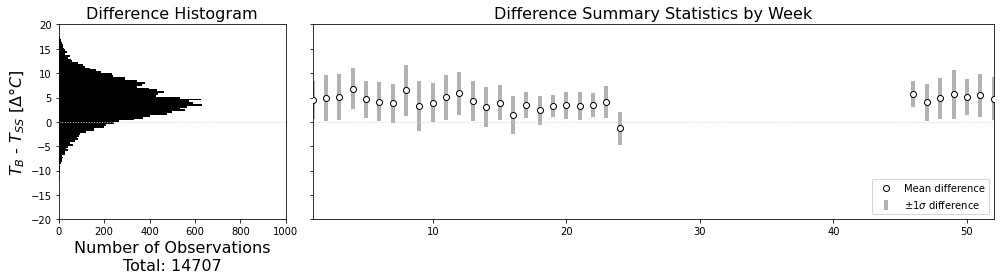

In [22]:
# Create DataArrayResample object
resampled_ds = tuol_snow_abicloud.goes_tuol_diff.groupby('time.week')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)


def week_of_wy(week):
    ''' return week of wateryear (starting with 1st week of October = 1, ending with last week of September = 52)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if week>=40:
        return(week-39)
    else:
        return(week+13)

# calculate month of wateryear from calendar month
resampled_df['week_of_wateryear'] = [week_of_wy(week) for week in resampled_df.index]
#resampled_df.set_index('week_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(tuol_snow_abicloud.goes_tuol_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1000, nbins=100)

## Add GOES-ASTER difference by hour of day for this month
#x = sat_timeseries.index.week # Get weeks
#y = sat_timeseries.ast_goes_mean_diff_tb # Get GOES-ASTER mean difference for this month
#yerr_min = y - (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_min_rad2tbK)
#yerr_max = (sat_timeseries.ast_goes_goes_tb - sat_timeseries.ast_goes_max_rad2tbK) - y
#ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
        



# format axis, limits and labels
#ax[1].set_xlim((0,44))
#ax[1].set_xticks(np.concatenate((np.arange(40,52), np.arange(0,39))))
#month_labels = [ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
#ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Week')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Hour of Day, by Month groupby

T_B - T_ss, Month: 3
{
    'intercept': -0.4181231676961552,
    'max_diff': 18.484761556184488,
    'mean_diff': 4.501392314880413,
    'mean_squared_diff': 39.37317949439984,
    'median_diff': 4.635146093060749,
    'min_diff': -11.96753893062206,
    'n': 2193,
    'p_value': 0.0,
    'r_squared': 0.7157501114339287,
    'r_value': 0.8460201601817351,
    'range_diff': 30.45230048680655,
    'rms_diff': 6.274805135970347,
    'slope': 0.6506291606247292,
    'std_diff': 4.371572568531304,
    'std_err': 0.008759549571356417,
}
T_B - T_air, Month: 3
{
    'intercept': -4.419973385384536,
    'max_diff': 8.569915277632942,
    'mean_diff': -2.8398752029794436,
    'mean_squared_diff': 17.91803150534314,
    'median_diff': -3.043707198746715,
    'min_diff': -11.595316708399837,
    'n': 2193,
    'p_value': 0.0,
    'r_squared': 0.824347953938907,
    'r_value': 0.9079360957352158,
    'range_diff': 20.16523198603278,
    'rms_diff': 4.232969584741088,
    'slope': 0.7655572211049688

T_B - T_ss, Month: 12
{
    'intercept': -0.7110624383130766,
    'max_diff': 17.843366233519923,
    'mean_diff': 5.084745410067973,
    'mean_squared_diff': 46.251103596014595,
    'median_diff': 5.410233951107074,
    'min_diff': -17.55919769745912,
    'n': 2412,
    'p_value': 0.0,
    'r_squared': 0.5652303909081559,
    'r_value': 0.7518180570511431,
    'range_diff': 35.40256393097904,
    'rms_diff': 6.800816391876389,
    'slope': 0.5956531256522041,
    'std_diff': 4.516244868339988,
    'std_err': 0.010641472837755826,
}
T_B - T_air, Month: 12
{
    'intercept': -5.181447014762274,
    'max_diff': 8.805588455742143,
    'mean_diff': -3.2187475418391576,
    'mean_squared_diff': 22.81350585297907,
    'median_diff': -3.035178725730608,
    'min_diff': -19.951419919681342,
    'n': 2412,
    'p_value': 0.0,
    'r_squared': 0.750188520040071,
    'r_value': 0.866134239041542,
    'range_diff': 28.757008375423485,
    'rms_diff': 4.776348589977397,
    'slope': 0.6745248531579

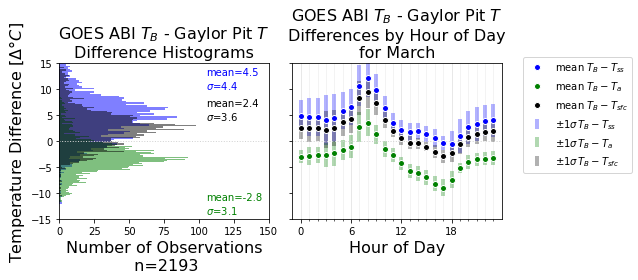

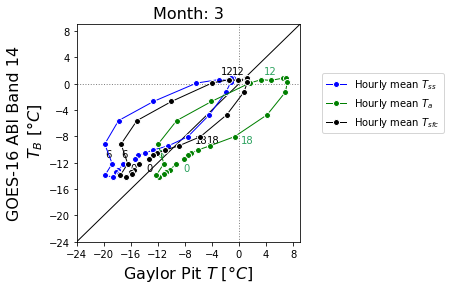

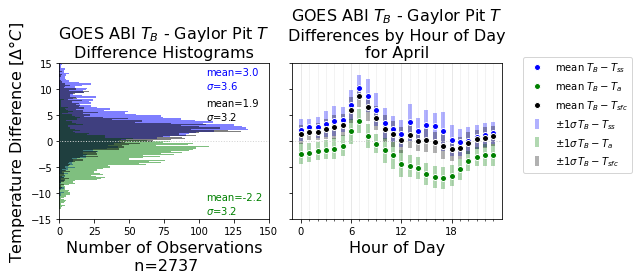

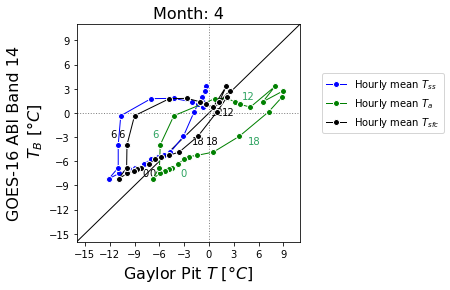

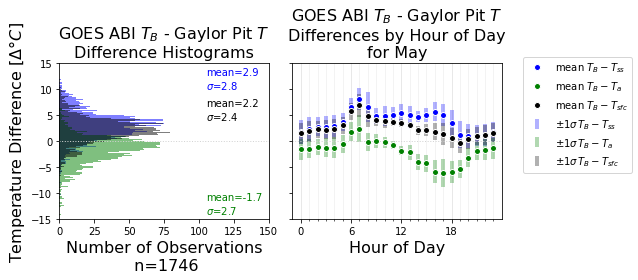

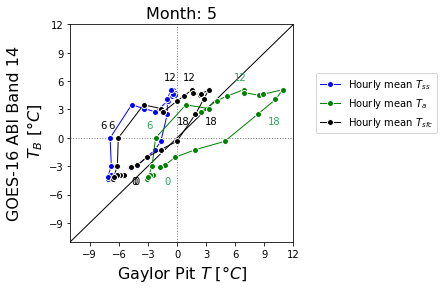

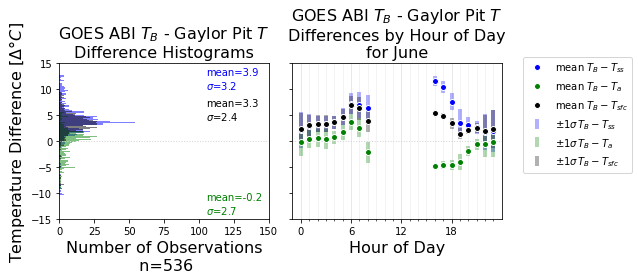

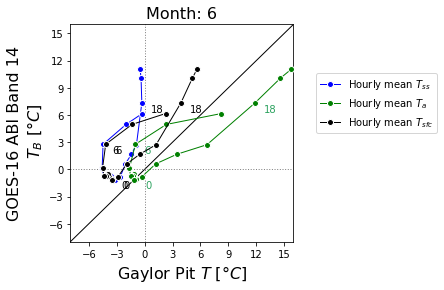

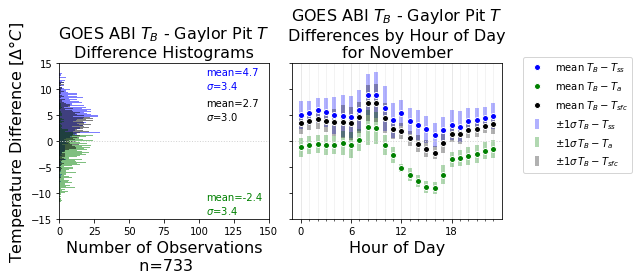

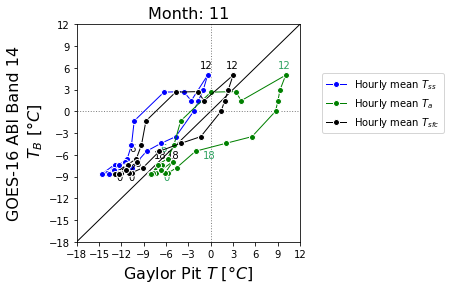

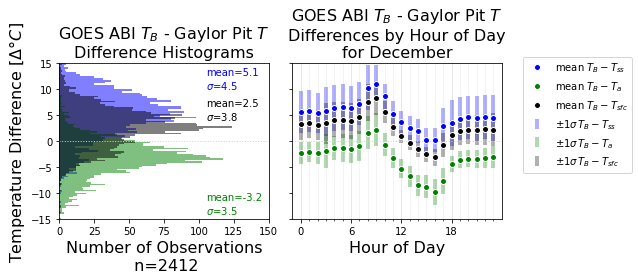

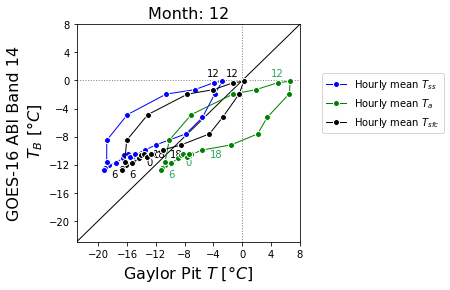

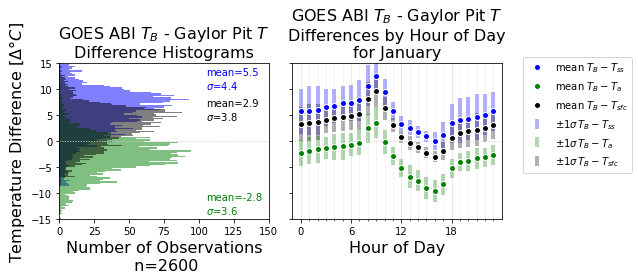

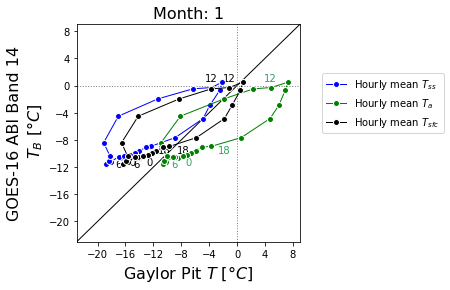

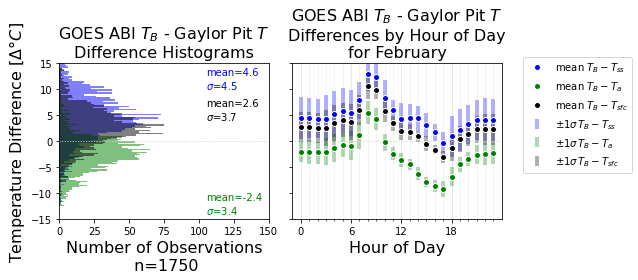

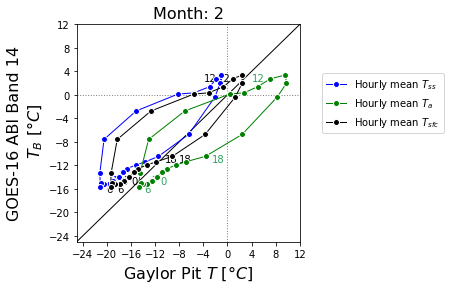

In [23]:
df = tuol_snow_abicloud.to_dataframe()

for month in df.index.month.unique():
    month_name = dt.date(1900, month, 1).strftime('%B')
    mask = df.index.month==month
    df_m = df.loc[mask]
    
    # Only look at aggregate months were we have data points (skipping summer months)
    if df_m.goes_tuol_diff.count() >= 1:
        
        # Compute summary stats for this aggregated month
        x = df_m.tss
        x2 = df_m.air_temp_c
        x3 = df_m.sfc_temp_c
        y = df_m.goes_tb_c
        print("T_B - T_ss, Month: {}".format(month))
        original_summary_stats = rs.summary_stats(x, y)
        pprint.pprint(original_summary_stats)
        print("T_B - T_air, Month: {}".format(month))
        original_summary_stats2 = rs.summary_stats(x2, y)
        pprint.pprint(original_summary_stats2)
        print("T_B - T_sfc, Month: {}".format(month))
        original_summary_stats3 = rs.summary_stats(x3, y)
        pprint.pprint(original_summary_stats3)
        
        
        ## Make a 1-to-1 plot for the same data in the histogram
        #plt.figure(figsize=(4,4))
        #plt.title('Month: {}'.format(month))
        #plt.plot(x, y, '.k',alpha=1, markersize=1)
        #(min_lim, max_lim) = (-40, 40)
        #plt.xlim((min_lim,max_lim))
        #plt.ylim((min_lim,max_lim));
        #plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
        #plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
        #plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

        # Create DataArrayResample object
        resampled_ds = df_m.groupby(df_m.index.hour)
        # Run the resampled_stats function
        resampled_df_tss = rs.resampled_stats(resampled_ds.goes_tuol_diff, 0)
        resampled_df_tair = rs.resampled_stats(resampled_ds.goes_tuol_airtemp_diff, 0)
        resampled_df_tsfc = rs.resampled_stats(resampled_ds.goes_tuol_sfc_temp_diff, 0)
        
        # Plot the results
        nbins = 100#int(np.sqrt(df_m.goes_cues_diff.count()))+1
        #fig, ax = rs.resampled_plot(df_m.goes_tuol_diff, resampled_df, ymin=-15, ymax=15, xmin=0, xmax=500, nbins=nbins)
        
        fig, ax = rs.resampled_plot3(df_m.goes_tuol_diff, resampled_df_tss,
                                     df_m.goes_tuol_airtemp_diff, resampled_df_tair,
                                     df_m.goes_tuol_sfc_temp_diff, resampled_df_tsfc,
                                     ymin=-15, ymax=15, xmin=0, xmax=150, nbins=nbins,
                                     color1=color1,color2=color2,color3=color3)
        
        ax[0].set_title('GOES ABI $T_{B}$ - Gaylor Pit $T_{}$\nDifference Histograms')
        ax[0].set_ylabel('Temperature Difference [$\Delta\degree C$]')
        ax[1].set_title('GOES ABI $T_{B}$ - Gaylor Pit $T_{}$\nDifferences by Hour of Day\nfor ' + month_name)
        ax[1].set_xlabel('Hour of Day')
        ax[1].legend(loc=(1.1,.3))                        
        ## Add GOES-ASTER difference by hour of day for this month
        #x = sat_timeseries.index.hour.where(sat_timeseries.index.month==month) # Get hour of day for this month
        #y = sat_timeseries.ast_goes_mean_diff_tb.where(sat_timeseries.index.month==month) # Get GOES-ASTER mean difference for this month
        #yerr_min = y - (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month))
        #yerr_max = (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month)) - y
        #ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
        # Set major ticks and add grid
        ax[1].set_xticks(np.arange(0,24,6))
        ax[1].set_xticks(np.arange(0,24,1), minor = True)
        ax[1].set_xlim((-1,24))
        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
        
        ### add another 1-to-1 plot
        resampled_x_tss = resampled_ds.tss 
        resampled_x_tair = resampled_ds.air_temp_c #air_temp_c if we want to look at air temp
        resampled_y = resampled_ds.goes_tb_c
        resampled_x_tsfc = resampled_ds.sfc_temp_c
        fig3, ax3 = plt.subplots(figsize=(4,4))
        ax3.set_title('Month: {}'.format(month))
        ax3.plot(rs.resampled_stats(resampled_x_tss, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor=color1,markeredgecolor='w', color=color1, lw=1, zorder=99, label='Hourly mean $T_{ss}$')
        ax3.plot(rs.resampled_stats(resampled_x_tair, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor=color2,markeredgecolor='w', color=color2, lw=1, zorder=99, label='Hourly mean $T_{a}$')                         
        ax3.plot(rs.resampled_stats(resampled_x_tsfc, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor=color3,markeredgecolor='w', color=color3, lw=1, zorder=99, label='Hourly mean $T_{sfc}$')
        #ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
        #ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
                                     
        # Add text labels for each hour
        linregress = stats.linregress(rs.resampled_stats(resampled_x_tss, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x_tss, 0)['means'] + linregress.intercept)])
        sign[sign==0] = -1
        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
            if i % 6 == 0:
                ax3.annotate(txt, 
                             xy=(rs.resampled_stats(resampled_x_tss, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             xytext=(rs.resampled_stats(resampled_x_tss, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             fontsize=10) #arrowprops={'width':0, 'headwidth':0})
        # Add text labels for each hour
        linregress = stats.linregress(rs.resampled_stats(resampled_x_tair, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x_tair, 0)['means'] + linregress.intercept)])
        sign[sign==0] = -1
        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
            if i % 6 == 0:
                ax3.annotate(txt, 
                             xy=(rs.resampled_stats(resampled_x_tair, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             xytext=(rs.resampled_stats(resampled_x_tair, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             fontsize=10, c='#2ca25f') #arrowprops={'width':0, 'headwidth':0})
        # Add text labels for each hour
        linregress = stats.linregress(rs.resampled_stats(resampled_x_tsfc, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x_tsfc, 0)['means'] + linregress.intercept)])
        sign[sign==0] = -1
        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
            if i % 6 == 0:
                ax3.annotate(txt, 
                             xy=(rs.resampled_stats(resampled_x_tsfc, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             xytext=(rs.resampled_stats(resampled_x_tsfc, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
                             fontsize=10, c=color3) #arrowprops={'width':0, 'headwidth':0})

        
        
        ## Get ASTER (mean aggregated to GOES pixel size) Tb values for this month
        #x = sat_timeseries.ast_goes_mean_rad2tbK.where(sat_timeseries.index.month==month) - 273.15
        ## Get corresponding GOES value for these ASTER observations
        #y = sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - 273.15
        #
        ## Get ASTER min and maximum values (these are the min and max values of ASTER pixels under the GOES pixel footprint)
        #xerr_min = abs(x - (sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month) - 273.15))
        #xerr_max = abs((sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month) - 273.15) - x)
        #print(x)
        ## Plot ASTER Tb vs GOES Tb
        #ax3.plot(x, y,  linestyle='none',marker='o',markerfacecolor='r',markeredgecolor='r', label='ASTER vs GOES Tb')
        ## Plot ASTER min/max error bars
        #ax3.errorbar(x, y,
        #         xerr=[xerr_min, xerr_max],
        #         fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='r', linewidth=1, capsize=3)
    
        
        #ax_lim_min = -25 #min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
        #ax_lim_max = 25 #max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
        ax_lim_min = int(np.min([ ax3.get_xlim()[0], ax3.get_ylim()[0] ])) - 3
        ax_lim_max = int(np.min([15, np.max([ ax3.get_xlim()[1], ax3.get_ylim()[1] ])]) + 1 )
        ax3.plot([ax_lim_min, ax_lim_max],[ax_lim_min, ax_lim_max],linestyle='-',color='k', lw=1)
        ax3.set_xlim((ax_lim_min,ax_lim_max))
        ax3.set_ylim((ax_lim_min,ax_lim_max))
        #ax3.grid('off')
        ax3.axhline(0, color='grey', lw=1, ls=':')
        ax3.axvline(0, color='grey', lw=1, ls=':')
        ax3.get_xaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
        ax3.get_yaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
        ax3.set_xlabel('Gaylor Pit $T$ [$\degree C$]')
        ax3.set_ylabel('GOES-16 ABI Band 14\n $T_{B}$ [$\degree C$]');
        ax3.legend(loc=(1.1,0.5))

In [24]:
#df = tuol_snow_abicloud.to_dataframe()
#
#for month in df.index.month.unique():
#    month_name = dt.date(1900, month, 1).strftime('%B')
#    mask = df.index.month==month
#    df_m = df.loc[mask]
#    
#    # Only look at aggregate months were we have data points (skipping summer months)
#    if df_m.goes_tuol_diff.count() >= 1:
#        
#        # Compute summary stats for this aggregated month
#        x = df_m.tss
#        y = df_m.goes_tb_c
#        print("Month: {}".format(month))
#        original_summary_stats = rs.summary_stats(x, y)
#        pprint.pprint(original_summary_stats)
#        # Make a 1-to-1 plot for the same data in the histogram
#        plt.figure(figsize=(4,4))
#        plt.title('Month: {}'.format(month))
#        plt.plot(x, y, '.k',alpha=1, markersize=1)
#        (min_lim, max_lim) = (-40, 40)
#        plt.xlim((min_lim,max_lim))
#        plt.ylim((min_lim,max_lim));
#        plt.xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
#        plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
#        plt.plot([min_lim,max_lim],[min_lim,max_lim],'-k')
#
#        # Create DataArrayResample object
#        resampled_ds = df_m.groupby(df_m.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds.goes_tuol_diff, 0)
#        
#        # Plot the results
#        nbins = 100#int(np.sqrt(df_m.goes_cues_diff.count()))+1
#        fig, ax = rs.resampled_plot(df_m.goes_tuol_diff, resampled_df, ymin=-15, ymax=15, xmin=0, xmax=500, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}'.format(month_name))
#        ax[1].set_xlabel('Hour of Day')
#        ax[1].legend(loc='lower right')
#        ## Add GOES-ASTER difference by hour of day for this month
#        #x = sat_timeseries.index.hour.where(sat_timeseries.index.month==month) # Get hour of day for this month
#        #y = sat_timeseries.ast_goes_mean_diff_tb.where(sat_timeseries.index.month==month) # Get GOES-ASTER mean difference for this month
#        #yerr_min = y - (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month))
#        #yerr_max = (sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month)) - y
#        #ax[1].errorbar(x, y, yerr=[yerr_min, yerr_max], fmt='o', color='r', linewidth=1, capsize=3)
#        # Set major ticks and add grid
#        ax[1].set_xticks(np.arange(0,24,6))
#        ax[1].set_xticks(np.arange(0,24,1), minor = True)
#        ax[1].set_xlim((-1,24))
#        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
#        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
#        
#        ### add another 1-to-1 plot
#        resampled_x = resampled_ds.tss #air_temp_c if we want to look at air temp
#        resampled_y = resampled_ds.goes_tb_c
#        fig3, ax3 = plt.subplots(figsize=(4,4))
#        ax3.set_title('Month: {}'.format(month))
#        ax3.plot(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='-',marker='o',markerfacecolor='w',markeredgecolor='k', color='k', lw=1, zorder=99, label='Hourly Mean')
#        #ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='^',markerfacecolor='none',markeredgecolor='k', zorder=98, label='Hourly Median')
#        #ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='+',color='k', zorder=97, label='Hourly Mode')
#        # Add text labels for each hour
#        linregress = stats.linregress(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'])
#        sign = np.array([int(tf) for tf in list(rs.resampled_stats(resampled_y, 0)['means'] > linregress.slope*rs.resampled_stats(resampled_x, 0)['means'] + linregress.intercept)])
#        sign[sign==0] = -1
#        for i, txt in enumerate(list(rs.resampled_stats(resampled_y, 0).index.values)):
#            if i % 6 == 0:
#                ax3.annotate(txt, 
#                             xy=(rs.resampled_stats(resampled_x, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
#                             xytext=(rs.resampled_stats(resampled_x, 0)['means'][i]-sign[i]*1, rs.resampled_stats(resampled_y, 0)['means'][i]+sign[i]*1),
#                             fontsize=10,
#                            )#arrowprops={'width':0, 'headwidth':0})
#
#        
#        
#        ## Get ASTER (mean aggregated to GOES pixel size) Tb values for this month
#        #x = sat_timeseries.ast_goes_mean_rad2tbK.where(sat_timeseries.index.month==month) - 273.15
#        ## Get corresponding GOES value for these ASTER observations
#        #y = sat_timeseries.ast_goes_goes_tb.where(sat_timeseries.index.month==month) - 273.15
#        #
#        ## Get ASTER min and maximum values (these are the min and max values of ASTER pixels under the GOES pixel footprint)
#        #xerr_min = x - (sat_timeseries.ast_goes_min_rad2tbK.where(sat_timeseries.index.month==month) - 273.15)
#        #xerr_max = (sat_timeseries.ast_goes_max_rad2tbK.where(sat_timeseries.index.month==month) - 273.15) - x
#        #
#        ## Plot ASTER Tb vs GOES Tb
#        #ax3.plot(x, y,  linestyle='none',marker='o',markerfacecolor='r',markeredgecolor='r', label='ASTER vs GOES Tb')
#        #
#        ## Plot ASTER min/max error bars
#        #ax3.errorbar(x, y,
#        #         xerr=[xerr_min, xerr_max],
#        #         fmt='none', label='min/max ASTER Tb within GOES pixel footprint', color='r', linewidth=1, capsize=3)
#    
#        
#        #ax_lim_min = -25 #min(-5, ax3.get_xlim()[0], ax3.get_ylim()[0])
#        #ax_lim_max = 25 #max(5, ax3.get_xlim()[1], ax3.get_ylim()[1])
#        ax_lim_min = int(np.min([ ax3.get_xlim()[0], ax3.get_ylim()[0] ])) - 3
#        ax_lim_max = int(np.min([15, np.max([ ax3.get_xlim()[1], ax3.get_ylim()[1] ])]) + 1 )
#        ax3.plot([ax_lim_min, ax_lim_max],[ax_lim_min, ax_lim_max],linestyle='-',color='k', lw=1)
#        ax3.set_xlim((ax_lim_min,ax_lim_max))
#        ax3.set_ylim((ax_lim_min,ax_lim_max))
#        #ax3.grid('off')
#        ax3.axhline(0, color='grey', lw=1, ls=':')
#        ax3.axvline(0, color='grey', lw=1, ls=':')
#        ax3.get_xaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
#        ax3.get_yaxis().set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
#        ax3.set_xlabel('Gaylor Pit\nSnow Surface Temperature [$\degree C$]')
#        ax3.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
#        ax3.legend(loc=(1.1,0.5))